In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
# Download Maestro = Midi Files 
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
     'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [5]:
# Process a Midi file 
sample_file = filenames[1]
print(sample_file)

data\maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi


In [6]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [8]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [9]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [10]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 37241


In [11]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [12]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [13]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  #Returns TF Dataset of sequence and label examples.
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [15]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset

# Aufteilung der Daten in Trainings- und Validierungsdaten | 80/20
split = int(0.8 * buffer_size)

# skip und take 80%
train_ds = (seq_ds
            .shuffle(buffer_size)
            .take(split)  
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

validation_ds = (seq_ds
                 .shuffle(buffer_size)
                 .skip(split)
                 .batch(batch_size, drop_remainder=True)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [16]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [17]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='mse_with_positive_pressure')
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [18]:
def build_model(hp):
    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.LSTM(hp.Int('units', min_value=64, max_value=256, step=32))(inputs)  # Hier variieren wir die Anzahl der LSTM-Einheiten

    pitch_output = tf.keras.layers.Dense(128, name='pitch')(x)
    step_output = tf.keras.layers.Dense(1, name='step')(x)
    duration_output = tf.keras.layers.Dense(1, name='duration')(x)

    model = tf.keras.Model(inputs, [pitch_output, step_output, duration_output])

    # Kompilieren des Modells mit der optimierten Lernrate
    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Hier variieren wir die Lernrate
        )
    )
    return model

In [19]:
# new version only
#loss = {
#    'pitch': SparseCategoricalCrossentropy(from_logits=True),
#    'step': MeanSquaredError(),    
#    'duration': MeanSquaredError()
#}

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

input_shape = (seq_length, 3)
# learning_rate = 0.005
# optimizer = Adam(learning_rate=learning_rate)


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='loss',
    max_epochs=25,
    hyperband_iterations=2
)

# Definition des Hyperparameter-Raums und Suche nach den besten Hyperparametern
tuner.search(train_ds, validation_data = validation_ds)

# Erhalten der besten Hyperparametern
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Erstellen des finalen Modells mit den besten Hyperparametern
best_model = tuner.hypermodel.build(best_hps)

Trial 28 Complete [00h 03m 07s]
loss: 3.906087875366211

Best loss So Far: 2.7048873901367188
Total elapsed time: 00h 32m 49s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
64                |224               |units
0.01              |0.01              |learning_rate
25                |25                |tuner/epochs
0                 |9                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/25
465/465 [==============================] - 5s 8ms/step - loss: 4.0866 - pitch_loss: 3.9487 - step_loss: 0.0446 - duration_loss: 0.0933 - val_loss: 4.0233 - val_pitch_loss: 3.8714 - val_step_loss: 0.0576 - val_duration_loss: 0.0943
Epoch 2/25
465/465 [==============================] - 3s 7ms/step - loss: 3.9791 - pitch_loss: 3.8609 - step_loss: 0.0366 - duration_loss: 0.0816 - val_loss: 3.9756 - val_pitch_loss: 3.8249 - val_step_loss: 0.0559 - val_duration_loss: 0.0948
E

In [21]:
best_model.save('models/tuner_best_mode.keras')
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 224)                  204288    ['input_1[0][0]']             
                                                                                                  
 pitch (Dense)               (None, 128)                  28800     ['lstm[0][0]']                
                                                                                                  
 step (Dense)                (None, 1)                    225       ['lstm[0][0]']                
                                                                                              

In [22]:
#todo: richtig parameter? 
# Verlust und Metriken des Modells auf den Validierungsdaten berechnen 
loss_and_metrics = best_model.evaluate(validation_ds)

# Loss auf den Validierungsdaten ausgeben, sollte nahe 0 sein
print(f'Verlust (Loss) auf den Validierungsdaten: {loss_and_metrics[0]}')

# Weitere Metriken ausgeben (z. B. Mean Squared Error für Regressionsprobleme)
print(f'Mean Squared Error (MSE) auf den Validierungsdaten: {loss_and_metrics[1]}')
print(f'Mean Absolute Error (MAE) auf den Validierungsdaten: {loss_and_metrics[2]}')


116/116 [==============================] - 4s 7ms/step - loss: 5.2558 - pitch_loss: 4.8577 - step_loss: 0.0711 - duration_loss: 0.3270
Verlust (Loss) auf den Validierungsdaten: 5.255849838256836
Mean Squared Error (MSE) auf den Validierungsdaten: 4.857725620269775
Mean Absolute Error (MAE) auf den Validierungsdaten: 0.07108037173748016


In [23]:
#new version
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
    
    #Generates a note as a tuple of (pitch, step, duration), using a trained sequence model.

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions[0]
  step = predictions[1]
  duration = predictions[2]

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [24]:
sample_file = filenames[1]
raw_notes = midi_to_notes(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

In [25]:
# lädt nicht rein sondern nutzt hier erstelltest 
"""temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))"""

"temperature = 2.0\nnum_predictions = 120\n\nsample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)\n\n# The initial sequence of notes; pitch is normalized similar to training\n# sequences\ninput_notes = (\n    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))\n\ngenerated_notes = []\nprev_start = 0\nfor _ in range(num_predictions):\n  pitch, step, duration = predict_next_note(input_notes, model, temperature)\n  start = prev_start + step\n  end = start + duration\n  input_note = (pitch, step, duration)\n  generated_notes.append((*input_note, start, end))\n  input_notes = np.delete(input_notes, 0, axis=0)\n  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)\n  prev_start = start\n\ngenerated_notes = pd.DataFrame(\n    generated_notes, columns=(*key_order, 'start', 'end'))"

In [26]:
# load with best model
sample_file = filenames[4]
raw_notes = midi_to_notes(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

model = tf.keras.saving.load_model('models/tuner_best_mode.keras')


instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
# model nutzen was gespeichert wurde (hier muss nicht vorher model gesucht werden)
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 13ms/step


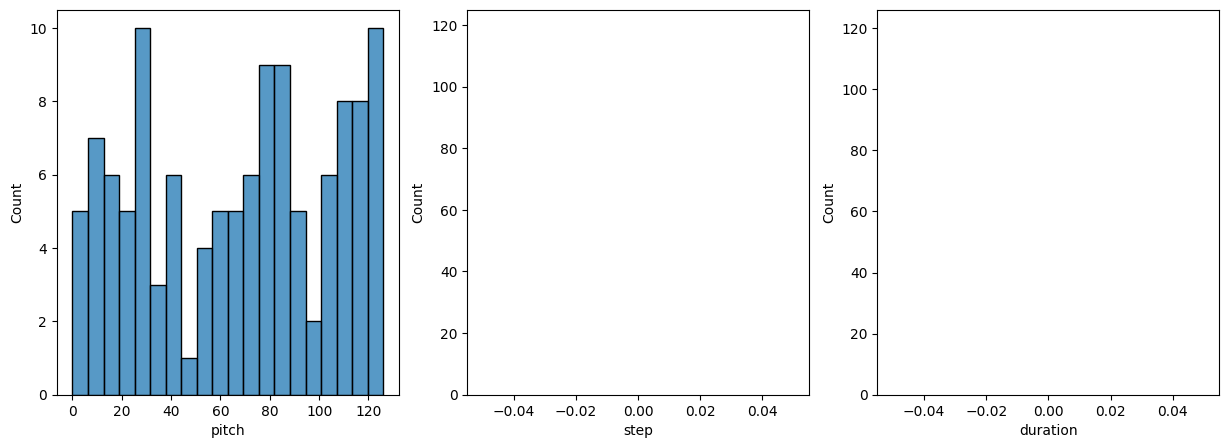

In [27]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  # todo: hier steht nichts  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

# Hier verwenden Sie die generierten Noten für den Plot
plot_distributions(generated_notes)

In [28]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [29]:
# todo: notwenig? 
#from google.colab import files
#files.download(out_file)

In [30]:
#plot_piano_roll(generated_notes)

In [31]:
#plot_distributions(generated_notes)